In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [ ]:
def ImportImage(folder):
    images = []
    filenames = []
    datalabel = []
    label_count = {}

    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            datalabel.append(label)
            label_count[label] = 0
            i = 0
            for filename in os.listdir(label_path):
                if i >= 150:
                    break
                file_path = os.path.join(label_path, filename)
                img = cv.imread(file_path)
                if img is not None:
                    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
                    img_resized = cv.resize(img_gray, (300, 300))
                    images.append((img_resized, label, filename))
                    label_count[label] += 1
                    i += 1
                    print(f"Processed {filename} in label {label}")

    return images, datalabel, label_count

images, labels, label_count = ImportImage("/content/drive/MyDrive/samples")


Processed 18_F1D022072_2_3.jpg in label finger_2
Processed 18_F1D022072_2_1.jpg in label finger_2
Processed 07_F1D022100_2_3.jpg in label finger_2
Processed 07_f1d022011_2_3.jpg in label finger_2
Processed 07_f1d022011_2_1.jpg in label finger_2
Processed 13_F1D022077_2_1.jpg in label finger_2
Processed 13_F1D022077_2_2.jpg in label finger_2
Processed 07_f1d022056_2_1.jpg in label finger_2
Processed 07_f1d022056_2_2.jpg in label finger_2
Processed 07_f1d022056_2_3.jpg in label finger_2
Processed 18_F1D022072_2_2.jpg in label finger_2
Processed 07_F1D022070_2_1.jpg in label finger_2
Processed 07_F1D022070_2_2.jpg in label finger_2
Processed 14_F1D022005_2_1.jpg in label finger_2
Processed 14_F1D022005_2_2.jpg in label finger_2
Processed 00_f1d021110_3_1.jpg in label finger_3
Processed 09_f1d022101_3_1.jpg in label finger_3
Processed 06_f1d022068_3_3.jpg in label finger_3
Processed 07_F1D022100_3_1.jpg in label finger_3
Processed 07_f1d022011_3_3.jpg in label finger_3
Processed 07_f1d0220

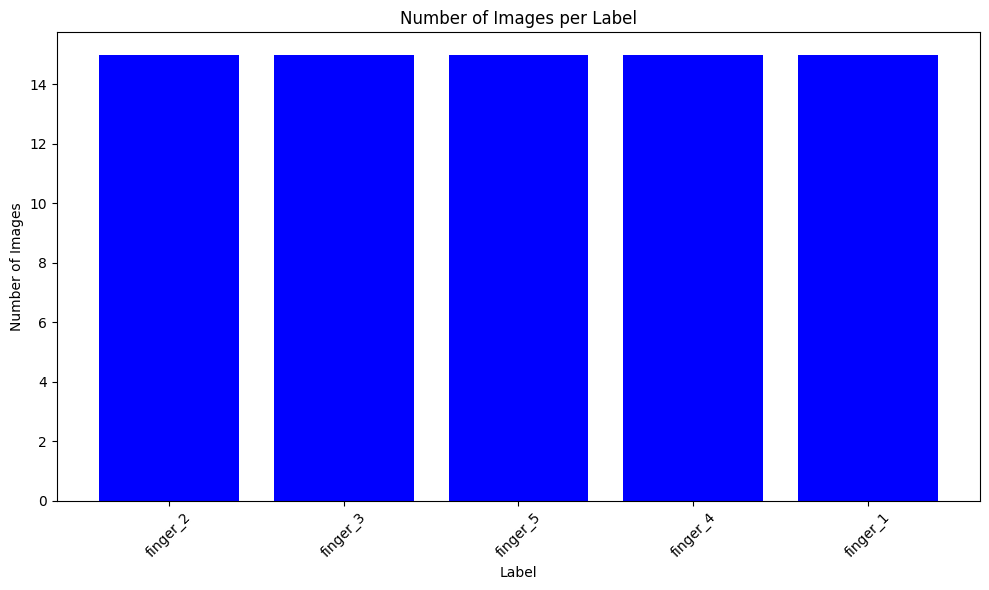

In [ ]:
def plot_label(label_count):
    plt.figure(figsize=(10, 6))
    plt.bar(label_count.keys(), label_count.values(), color='blue')
    plt.xlabel('Label')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_label(label_count)


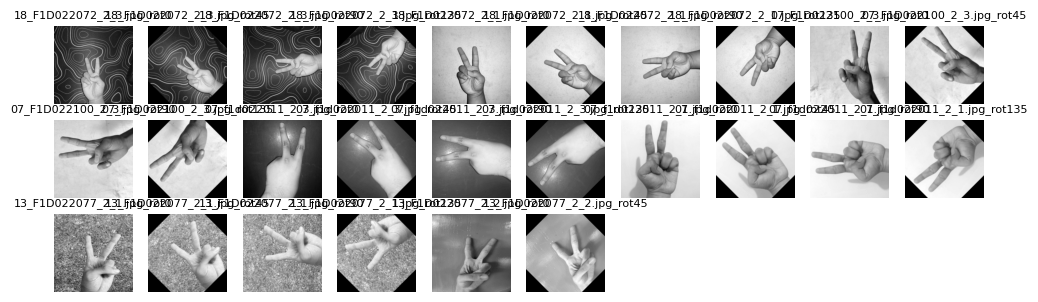

300


In [ ]:
def apply_rotations(images):
    rotated_images = []
    rotated_filenames = []
    rotated_label_count = {}

    for img, label, filename in images:
        rotation_count = 0  # Counter for the number of rotated images for each label

        for angle in [0, 45, 90, 135]:
            if rotation_count >= 50:  # Break the loop once 50 rotated images for the label are reached
                break

            (h, w) = img.shape[:2]
            center = (w / 2, h / 2)
            M = cv.getRotationMatrix2D(center, angle, 1.0)
            img_rotated = cv.warpAffine(img, M, (w, h))
            rotated_images.append((img_rotated, label, f"{filename}_rot{angle}"))

            # Update rotated image count for the label
            if label not in rotated_label_count:
                rotated_label_count[label] = 0
            rotated_label_count[label] += 1

            rotation_count += 1  # Increment the counter after adding a rotated image

    return rotated_images, rotated_filenames, rotated_label_count

def display_images(images):
    plt.figure(figsize=(12, 12))
    for idx in range(len(images)):
        img, label, filename = images[idx]
        plt.subplot(10, 10, idx + 1)
        plt.imshow(img, cmap='gray')
        plt.title(filename, fontsize=8)
        plt.axis('off')
        if idx >= 25:
            break
    plt.show()

rotated_images, rotated_filenames, rotated_label_count = apply_rotations(images)

display_images(rotated_images)

print(len(rotated_images))

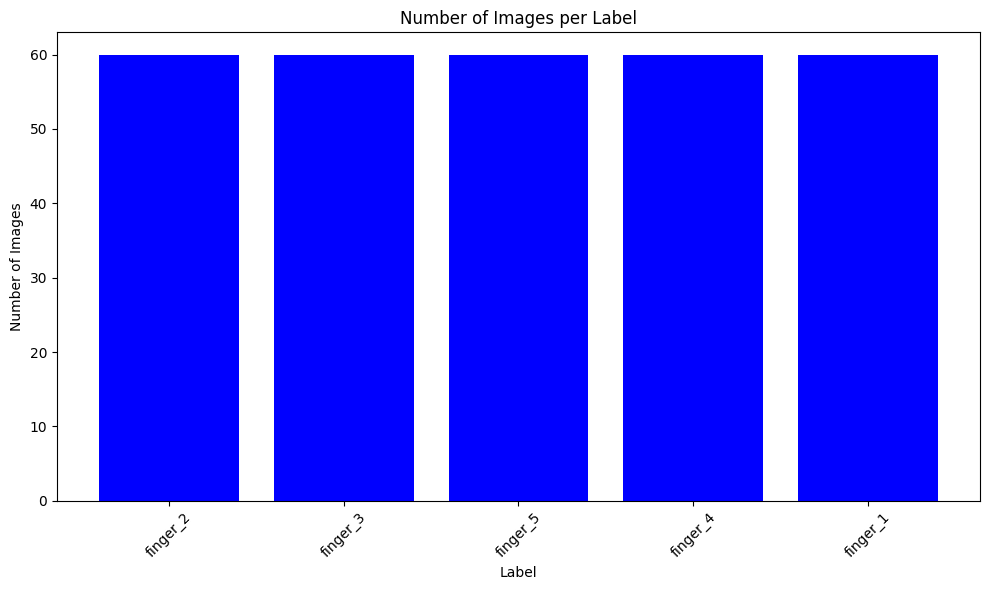

In [ ]:
plot_label(rotated_label_count)

In [ ]:
def konvolusi(image,kernel):
    pad_size = kernel.shape[0] // 2
    gambar_input = np.pad(image, pad_size, mode='constant')

    gambar_konvolusi = np.zeros_like(image).astype(np.float32)

    baris, kolom = image.shape

    for i in range(baris):
        for j in range(kolom):

            gambar_konvolusi[i, j] = np.sum(gambar_input[i:i + kernel.shape[0], j:j + kernel.shape[1]] * kernel)
    return gambar_konvolusi

kernelsmooth = np.array([[1/9, 1/9, 1/9],
                        [1/9, 8/9, 1/9],
                        [1/9, 1/9, 1/9]])

In [ ]:
def MagnitudeR(x, y):
    return (abs(x)+abs(y))

In [ ]:
smoothing = []
for img, label, filename in rotated_images:
    smoothed_img = konvolusi(img, kernelsmooth)
    smoothed_label = f"{label}_{filename}"
    smoothing.append((smoothed_img, smoothed_label))


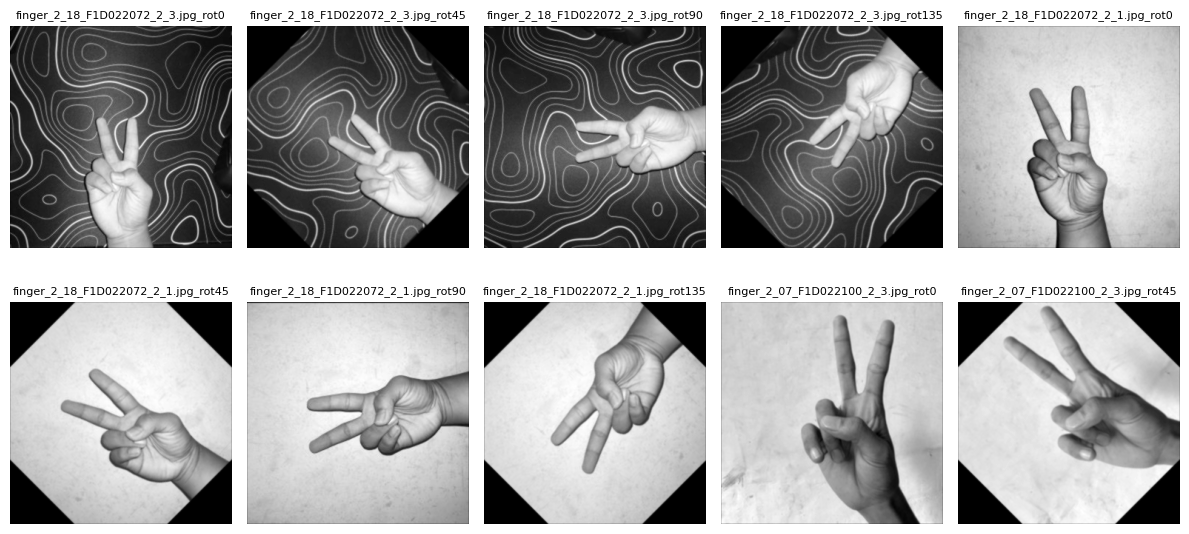

In [ ]:
num_rows = 2
num_cols = 5

plt.figure(figsize=(12, 6))
for idx, (smoothed_img, smoothed_label) in enumerate(smoothing[:10]):
    plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(smoothed_img, cmap='gray')
    plt.title(smoothed_label, fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
def contrast(image):
    intensity = np.mean(image)
    return np.sum((image - intensity) ** 2)

def dissimilarity(image):
    height, width = image.shape
    dissimilarity = 0
    for i in range(height):
        for j in range(width):
            dissimilarity += image[i, j] * abs(i - j)
    return dissimilarity

def Homogenitas(image):
    height, width = image.shape
    homogenitas = 0
    for i in range(height):
        for j in range(width):
            homogenitas += image[i, j] / (1.0 + abs(i - j))
    return homogenitas

def Entropi(image):
    height, width = image.shape
    entropi = 0
    for i in range(height):
        for j in range(width):
            if image[i, j] != 0:
                entropi -= image[i, j] * np.log2(image[i, j])
    return entropi

def ASM(image):
    return np.sum(image ** 2)

def Energi(image):
    return np.sum(image ** 2)

def Correlation(image):
    mean_x = np.mean(image)
    std_x = np.std(image)

    image_transpose = np.transpose(image)
    mean_y = np.mean(image_transpose)
    std_y = np.std(image_transpose)

    if std_x == 0 or std_y == 0:
        return 0
    else:
        return np.sum((image - mean_x) * (image_transpose - mean_y)) / (image.size * std_x * std_y)


In [ ]:
def Correlation(image):
    mean_x = np.mean(image)
    std_x = np.std(image)

    image_transpose = np.transpose(image)
    mean_y = np.mean(image_transpose)
    std_y = np.std(image_transpose)

    if std_x == 0 or std_y == 0:
        return 0
    else:
        return np.sum((image - mean_x) * (image_transpose - mean_y)) / (image.size * std_x * std_y)

def save_frame(result, filenames):
    frame = []
    for idx, img in enumerate(result):
        save = [filenames[idx]]
        save.append(contrast(img))
        save.append(dissimilarity(img))
        save.append(Homogenitas(img))
        save.append(Entropi(img))
        save.append(ASM(img))
        save.append(Energi(img))
        save.append(Correlation(img))
        frame.append(save)
    return frame


In [ ]:
headerPass = ['path', 'Kontras', 'Dissimilarity', 'Homogenitas', 'Entropi', 'ASM', 'Energy', 'Correlation']
frame = save_frame([img for img, _ in smoothing], [label for _, label in smoothing])
df = pd.DataFrame(frame, columns=headerPass)

In [ ]:
df

,path,Kontras,Dissimilarity,Homogenitas,Entropi,ASM,Energy,Correlation
0,finger_2_18_F1D022072_2_3.jpg_rot0,7.473148e+08,1.031382e+09,390040.762318,-8.587084e+07,2.272336e+09,2.272336e+09,0.061483
1,finger_2_18_F1D022072_2_3.jpg_rot45,8.801020e+08,7.467690e+08,456418.553820,-7.856355e+07,2.128725e+09,2.128725e+09,0.774220
2,finger_2_18_F1D022072_2_3.jpg_rot90,7.495157e+08,1.068123e+09,370666.664069,-8.576020e+07,2.270356e+09,2.270356e+09,0.156960
3,finger_2_18_F1D022072_2_3.jpg_rot135,8.802422e+08,1.002868e+09,312123.482052,-7.855464e+07,2.128575e+09,2.128575e+09,0.457310
4,finger_2_18_F1D022072_2_1.jpg_rot0,1.741845e+08,2.480082e+09,778315.778268,-2.026505e+08,7.072104e+09,7.072104e+09,-0.110646
...,...,...,...,...,...,...,...,...
295,finger_1_07_F1D022070_1_3.jpg_rot135,1.030782e+09,1.324373e+09,436557.381910,-1.094466e+08,3.256008e+09,3.256008e+09,0.560746
296,finger_1_14_F1D022005_1_3.jpg_rot0,5.550883e+08,1.449974e+09,394473.096048,-1.007019e+08,2.606411e+09,2.606411e+09,-0.089423
297,finger_1_14_F1D022005_1_3.jpg_rot45,7.332141e+08,9.929713e+08,353284.895632,-8.208024e+07,2.104716e+09,2.104716e+09,0.463123
298,finger_1_14_F1D022005_1_3.jpg_rot90,5.572353e+08,1.162147e+09,543118.169021,-1.004482e+08,2.598937e+09,2.598937e+09,0.414842


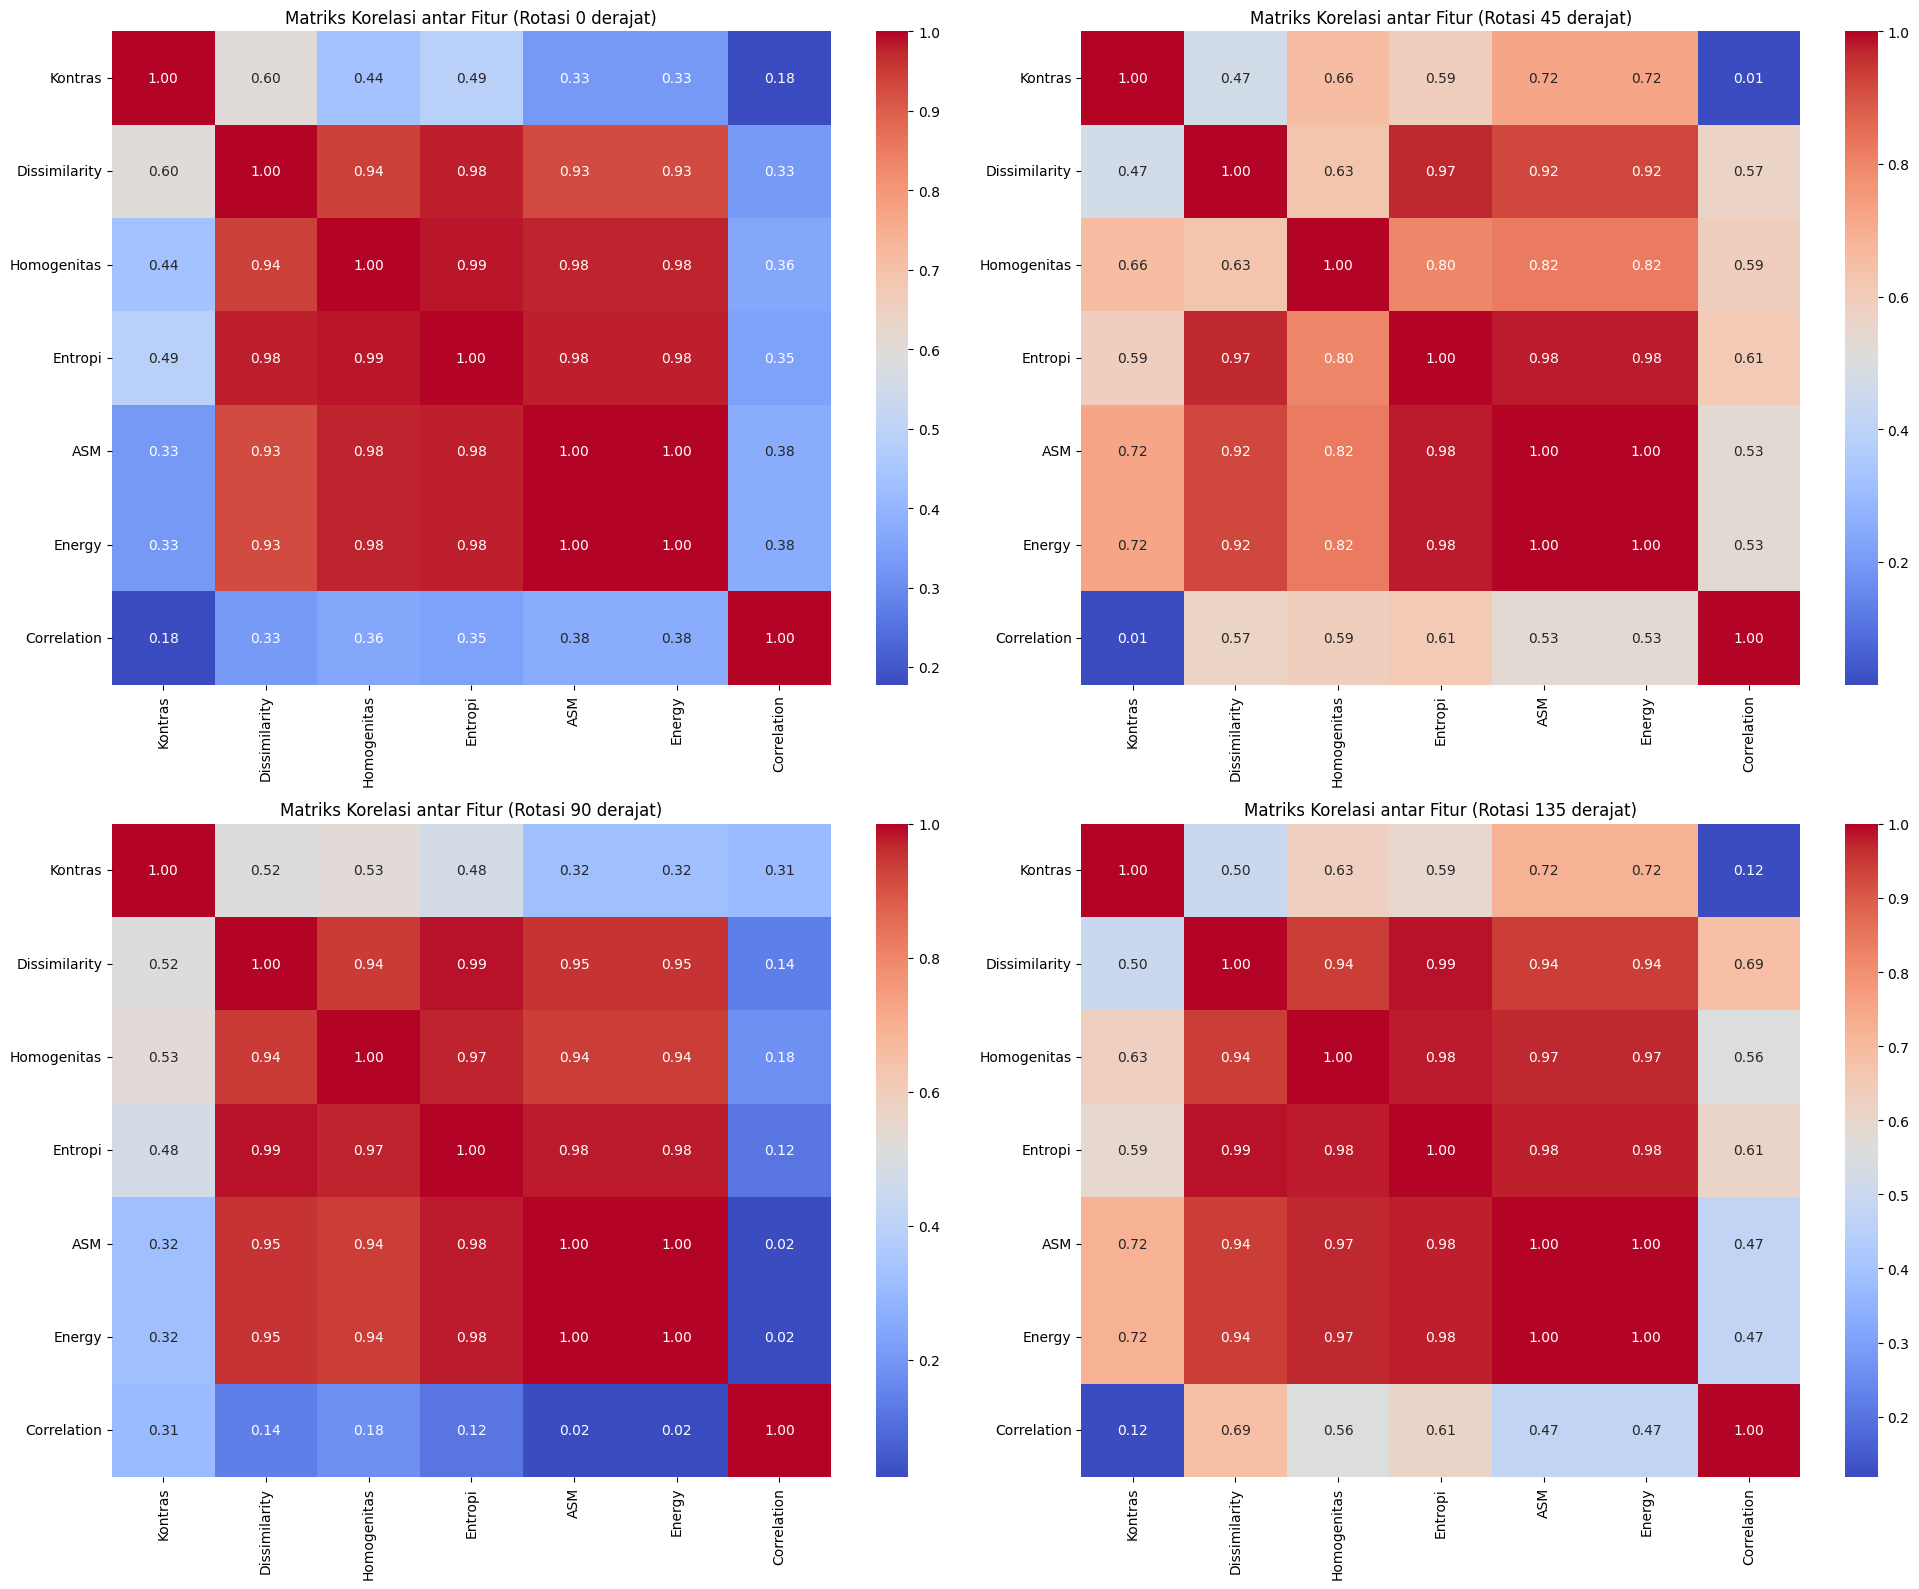

In [ ]:
df['rotation_angle'] = df['path'].str.extract(r'_rot(\d+)').astype(float)

grouped_df = df.groupby('rotation_angle')

correlation_matrices = [group.drop(columns=['path', 'rotation_angle']).corr().abs() for _, group in grouped_df]

plt.figure(figsize=(20, 16))
for idx, corr_matrix in enumerate(correlation_matrices):
    plt.subplot(2, 2, idx + 1)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Matriks Korelasi antar Fitur (Rotasi {idx * 45} derajat)')
plt.tight_layout()
plt.show()


In [ ]:
X = df.drop(columns=['path', 'rotation_angle'])
y = df['path']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [ ]:
def min_max_normalization(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = (df[numeric_columns] - df[numeric_columns].min()) / (df[numeric_columns].max() - df[numeric_columns].min())
    return df

In [ ]:
X_train = min_max_normalization(X_train)
X_test = min_max_normalization(X_test)
y_train = df['path'][X_train.index]
y_test = df['path'][X_test.index]

In [ ]:
X_train

,Kontras,Dissimilarity,Homogenitas,Entropi,ASM,Energy,Correlation
232,0.032867,0.223164,0.221878,0.878963,0.033915,0.033915,0.418171
59,0.224703,0.256878,0.185159,0.814293,0.113882,0.113882,0.780668
6,0.023180,0.690367,0.601604,0.384100,0.479052,0.479052,0.576385
185,0.412762,0.498826,0.353281,0.539915,0.386967,0.386967,0.912827
173,0.170923,0.102634,0.197423,0.932787,0.022997,0.022997,0.913658
...,...,...,...,...,...,...,...
188,0.071870,0.625481,0.429004,0.526883,0.338508,0.338508,0.544638
71,0.521529,0.144834,0.184252,0.868549,0.138817,0.138817,0.735538
106,0.070185,0.839971,0.747424,0.238088,0.659323,0.659323,0.455432
270,0.286702,0.302278,0.398658,0.705198,0.221350,0.221350,0.412587


In [ ]:
X_test

,Kontras,Dissimilarity,Homogenitas,Entropi,ASM,Energy,Correlation
203,0.723959,0.522568,0.475628,0.461386,0.497473,0.497473,0.929842
266,0.476449,0.516838,0.445512,0.597205,0.329917,0.329917,0.259892
152,0.000000,0.778459,0.748980,0.272538,0.613232,0.613232,0.499235
9,0.650507,0.467901,0.330805,0.582435,0.360120,0.360120,0.808153
233,0.293051,0.127056,0.172152,0.937623,0.001764,0.001764,0.884319
226,0.128297,0.982081,0.986183,0.023751,0.962299,0.962299,0.431801
196,0.122712,0.835589,0.821174,0.204537,0.718922,0.718922,0.275473
109,0.604636,0.356926,0.294496,0.664757,0.275432,0.275432,0.808836
5,0.759195,0.587355,0.475706,0.405666,0.563657,0.563657,0.974783
175,0.340212,0.193102,0.051557,0.916662,0.024618,0.024618,0.847564


In [ ]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train, y_train)

Rndfor = RandomForestClassifier(n_estimators=100, random_state=42)
Rndfor.fit(X_train, y_train)

SVM = SVC(kernel='rbf', random_state=42)
SVM.fit(X_train, y_train)

y_knn = KNN.predict(X_test)
y_rf = Rndfor.predict(X_test)
y_Svm = SVM.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_knn)
accuracy_rf = accuracy_score(y_test, y_rf)
accuracy_svm = accuracy_score(y_test, y_Svm)

In [ ]:
print("Report KNN")
print(accuracy_knn)
print("Report SVM")
print(accuracy_svm)
print("Report Random Forest")
print(accuracy_rf)

Report KNN
0.0
Report SVM
0.0
Report Random Forest
0.0


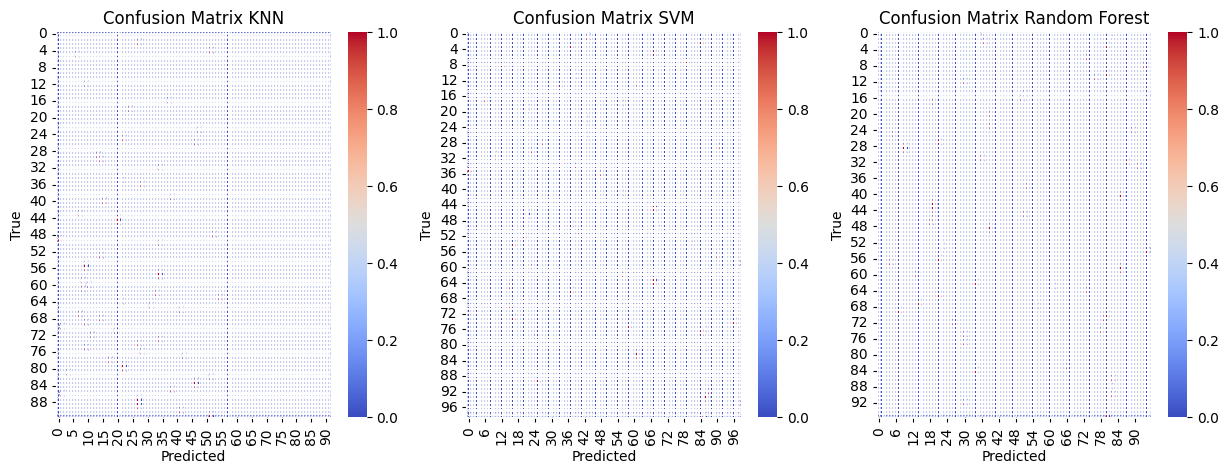

In [ ]:
cm_knn = confusion_matrix(y_test, y_knn)
cm_svm = confusion_matrix(y_test, y_Svm)
cm_rf = confusion_matrix(y_test, y_rf)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(cm_knn, annot=True, cmap='coolwarm', fmt='g', ax=axes[0])
axes[0].set_title('Confusion Matrix KNN')
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_svm, annot=True, cmap='coolwarm', fmt='g', ax=axes[1])
axes[1].set_title('Confusion Matrix SVM')
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

sns.heatmap(cm_rf, annot=True, cmap='coolwarm', fmt='g', ax=axes[2])
axes[2].set_title('Confusion Matrix Random Forest')
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("True")

plt.show()